<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'Matin Mb'
std_id = '400102114'

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os 

# Load Configurations `config.yaml`
with open("/kaggle/input/config-yaml/config.yaml", "r") as file:
    config = yaml.safe_load(file)

model_params = config['model_params']

# Part 1: Load MNIST dataset
def load_mnist(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] for GANs
    ])

    train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return dataloader

dataloader = load_mnist()

# Print dataset information
print(f"Number of training samples: {len(dataloader)}")



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6069561.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158679.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1514068.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2454965.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Number of training samples: 469


### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [6]:
# Part 2: Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, channels, kernels, strides, paddings, output_paddings):
        super(Generator, self).__init__()
        layers = []
        in_channels = latent_dim

        for out_channels, kernel, stride, padding, output_padding in zip(channels, kernels, strides, paddings, output_paddings):
            layers.append(
                nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding, output_padding, bias=False)
            )
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(True))
            in_channels = out_channels

        layers.append(nn.ConvTranspose2d(in_channels, 1, kernel_size=4, stride=2, padding=1))  # Final layer
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)

# Part 2: Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels, kernels, strides, paddings):
        super(Discriminator, self).__init__()
        layers = []
        in_channels = 1

        for out_channels, kernel, stride, padding in zip(channels, kernels, strides, paddings):
            layers.append(
                nn.Conv2d(in_channels, out_channels, kernel, stride, padding, bias=False)
            )
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            in_channels = out_channels

        # Adjusted final layer to handle smaller inputs
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=3, stride=1, padding=0, bias=False))  # Final layer
        layers.append(nn.Flatten())  # Flatten to ensure [batch_size]
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)


### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


[Epoch 1/30] [D loss: 0.008236515335738659] [G loss: 6.181643486022949]
[Epoch 2/30] [D loss: 0.23601439595222473] [G loss: 1.5220855474472046]
[Epoch 3/30] [D loss: 0.6876169443130493] [G loss: 0.40037697553634644]
[Epoch 4/30] [D loss: 0.6506314277648926] [G loss: 0.47624215483665466]
[Epoch 5/30] [D loss: 0.3052443861961365] [G loss: 1.4886541366577148]
[Epoch 6/30] [D loss: 0.424776554107666] [G loss: 2.4669387340545654]
[Epoch 7/30] [D loss: 0.3248826861381531] [G loss: 1.2740073204040527]
[Epoch 8/30] [D loss: 0.22926858067512512] [G loss: 2.180248260498047]
[Epoch 9/30] [D loss: 0.22768303751945496] [G loss: 1.4846150875091553]
[Epoch 10/30] [D loss: 0.26510632038116455] [G loss: 1.9619687795639038]


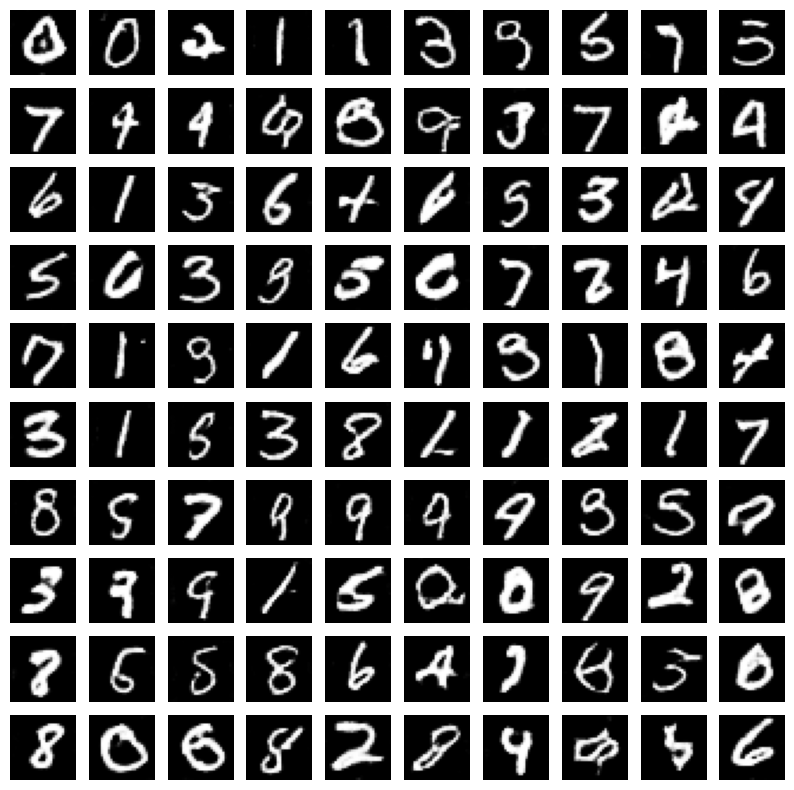

[Epoch 11/30] [D loss: 0.5852655172348022] [G loss: 4.06489896774292]
[Epoch 12/30] [D loss: 0.5925471186637878] [G loss: 4.185822486877441]
[Epoch 13/30] [D loss: 0.2199871987104416] [G loss: 2.197633743286133]
[Epoch 14/30] [D loss: 0.24961018562316895] [G loss: 3.142890453338623]
[Epoch 15/30] [D loss: 0.19487930834293365] [G loss: 1.809753179550171]
[Epoch 16/30] [D loss: 0.54804927110672] [G loss: 0.6457883715629578]
[Epoch 17/30] [D loss: 0.19869659841060638] [G loss: 2.3026604652404785]
[Epoch 18/30] [D loss: 0.16711227595806122] [G loss: 2.0207855701446533]
[Epoch 19/30] [D loss: 0.23903638124465942] [G loss: 1.5925242900848389]
[Epoch 20/30] [D loss: 0.38061532378196716] [G loss: 4.382039546966553]


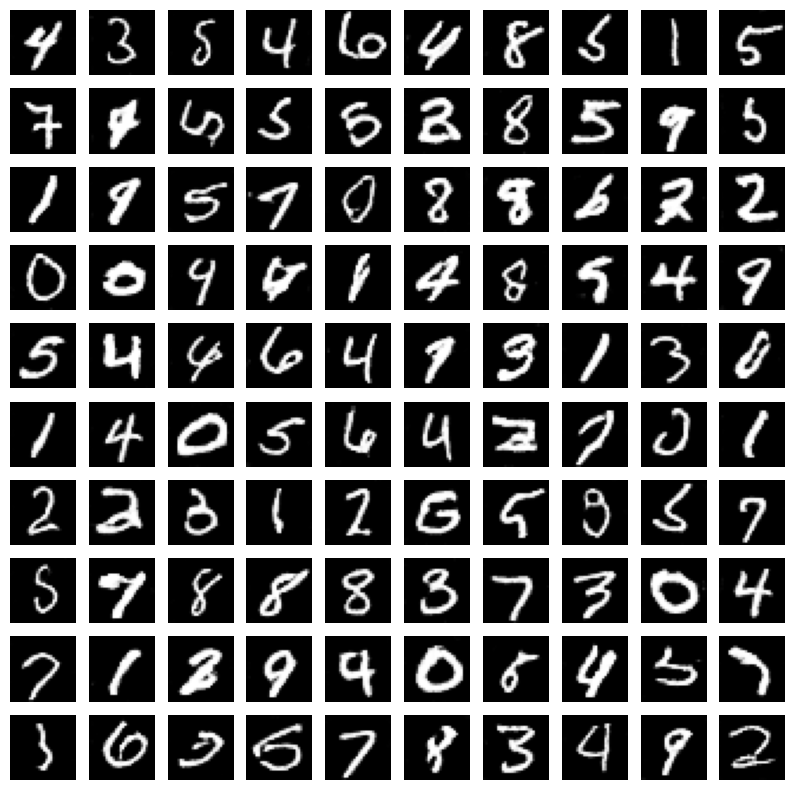

[Epoch 21/30] [D loss: 0.14808101952075958] [G loss: 2.5101943016052246]
[Epoch 22/30] [D loss: 0.37513041496276855] [G loss: 1.994856834411621]
[Epoch 23/30] [D loss: 0.4094315767288208] [G loss: 0.9158467650413513]
[Epoch 24/30] [D loss: 0.1371130645275116] [G loss: 2.354943037033081]
[Epoch 25/30] [D loss: 0.11389805376529694] [G loss: 2.9917173385620117]
[Epoch 26/30] [D loss: 0.24992650747299194] [G loss: 3.3947227001190186]
[Epoch 27/30] [D loss: 0.16280551254749298] [G loss: 3.2770462036132812]
[Epoch 28/30] [D loss: 0.26177072525024414] [G loss: 2.77882719039917]
[Epoch 29/30] [D loss: 0.17619360983371735] [G loss: 2.128483772277832]
[Epoch 30/30] [D loss: 0.09785091876983643] [G loss: 2.5441551208496094]


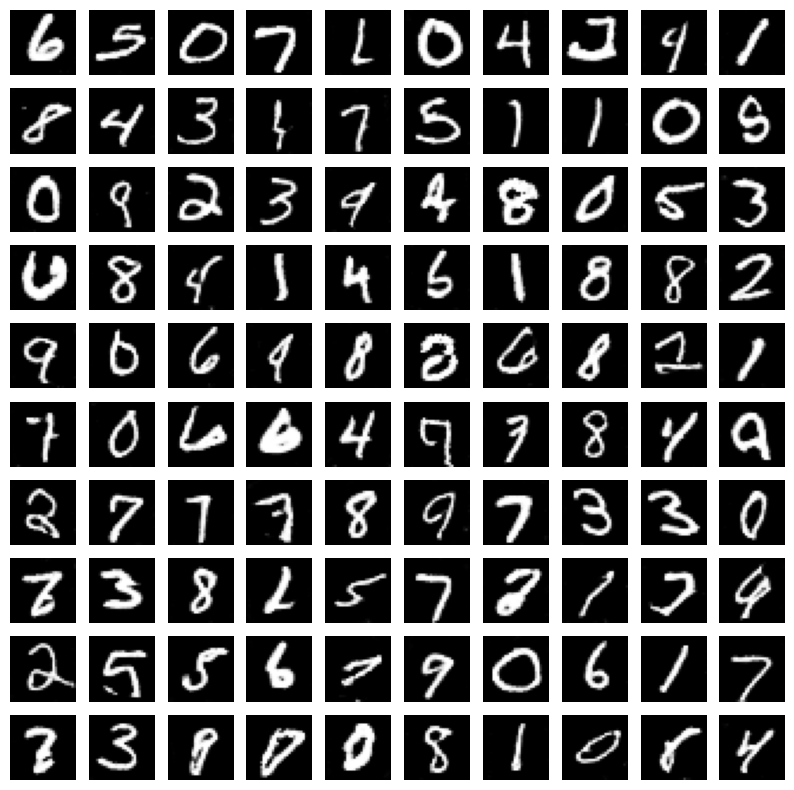

In [7]:
# Part 3: Training Function
def train_dcgan(generator, discriminator, dataloader, latent_dim, epochs=30, lr=0.0002, beta1=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    criterion = nn.BCELoss()

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)
            batch_size = imgs.size(0)

            # Real and fake labels
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)


            # Train Generator
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Random noise
            gen_imgs = generator(z)

            g_loss = criterion(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()


            # Train Discriminator
            optimizer_D.zero_grad()

            real_loss = criterion(discriminator(imgs), valid)
            fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        print(f"[Epoch {epoch+1}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # plot generated samples every 10 epochs
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                z = torch.randn(100, latent_dim, 1, 1, device=device)
                samples = generator(z).cpu()
                plot_generated_images(samples)

# Part 4: a Grid of Generated Samples
def plot_generated_images(samples):
    samples = (samples + 1) / 2  # Rescale to [0, 1]
    samples = samples.squeeze(1)  # Remove channel dimension

    grid_size = 10
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].detach().numpy(), cmap="gray")
        ax.axis("off")
    plt.show()


dataloader = load_mnist()
generator = Generator(
    latent_dim=model_params['latent_dim'],
    channels=model_params['generator_channels'],
    kernels=model_params['generator_kernels'],
    strides=model_params['generator_strides'],
    paddings=model_params['generator_paddings'],
    output_paddings=model_params['generator_output_paddings']
)
discriminator = Discriminator(
    channels=model_params['discriminator_channels'],
    kernels=model_params['discriminator_kernels'],
    strides=model_params['discriminator_strides'],
    paddings=model_params['discriminator_paddings']
)

train_dcgan(generator, discriminator, dataloader, latent_dim=model_params['latent_dim'])

### Part 4: Plot a grid of 100 generated samples.

In [ ]:
## Compeleted Above :)

### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


Step [50/500], Loss: 0.2043
Step [100/500], Loss: 0.1695
Step [150/500], Loss: 0.1239
Step [200/500], Loss: 0.1038
Step [250/500], Loss: 0.0955
Step [300/500], Loss: 0.0891
Step [350/500], Loss: 0.0842
Step [400/500], Loss: 0.0641
Step [450/500], Loss: 0.0566
Step [500/500], Loss: 0.0526


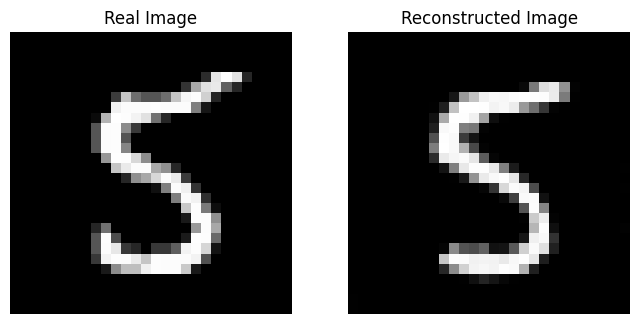

In [8]:
# Part 5: GAN Inversion
def gan_inversion(generator, dataloader, latent_dim, steps=500, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)

    # a random real image from the dataset
    real_img, _ = next(iter(dataloader))
    real_img = real_img[0:1].to(device)  # Take a single sample

    # a random latent vector
    z = torch.randn(1, latent_dim, 1, 1, device=device, requires_grad=True)

    # Freeze the generator
    generator.eval()
    for param in generator.parameters():
        param.requires_grad = False

    # Define optimizer for the latent vector
    optimizer = optim.Adam([z], lr=lr)
    criterion = nn.MSELoss()

    for step in range(steps):
        optimizer.zero_grad()

        # Generate an image from the latent vector
        gen_img = generator(z)
        loss = criterion(gen_img, real_img)
        loss.backward()
        optimizer.step()

        if (step + 1) % 50 == 0:
            print(f"Step [{step + 1}/{steps}], Loss: {loss.item():.4f}")


    real_img = (real_img + 1) / 2  # Rescale to [0, 1]
    gen_img = (gen_img + 1) / 2

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(real_img.squeeze(0).squeeze(0).cpu().detach().numpy(), cmap="gray")
    axs[0].set_title("Real Image")
    axs[0].axis("off")

    axs[1].imshow(gen_img.squeeze(0).squeeze(0).cpu().detach().numpy(), cmap="gray")
    axs[1].set_title("Reconstructed Image")
    axs[1].axis("off")

    plt.show()

gan_inversion(generator, dataloader, latent_dim=model_params['latent_dim'])


### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

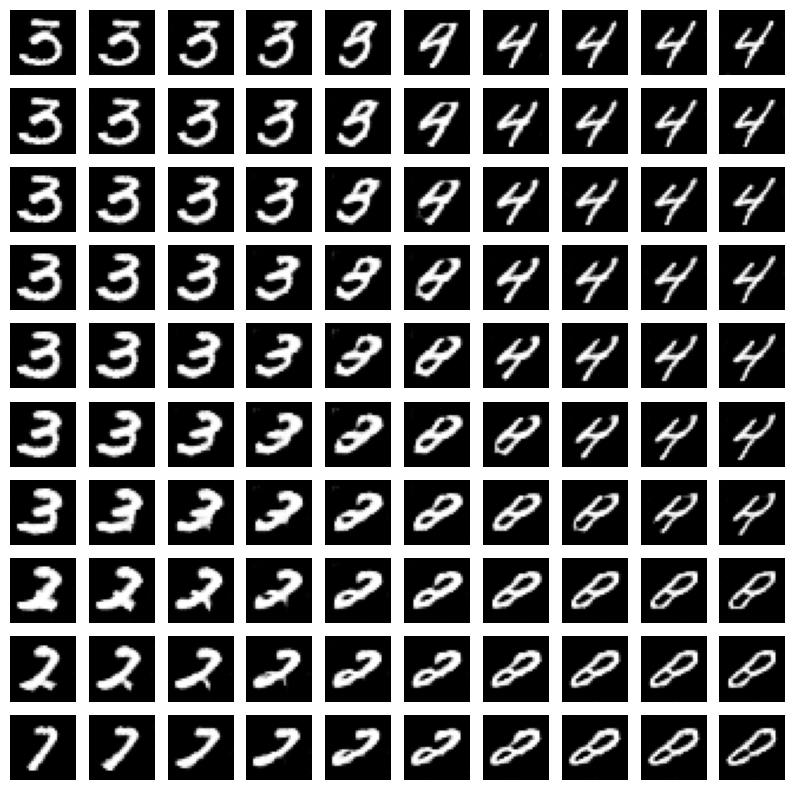

In [12]:
# Part 6: Interpolating the Latent Space
def interpolate_latent_space(generator, latent_dim, num_points=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    generator.eval()

    # 4 random latent vectors
    z1 = torch.randn(1, latent_dim, 1, 1, device=device)
    z2 = torch.randn(1, latent_dim, 1, 1, device=device)
    z3 = torch.randn(1, latent_dim, 1, 1, device=device)
    z4 = torch.randn(1, latent_dim, 1, 1, device=device)

    # grid points for interpolation
    grid = []
    for i in range(num_points):
        row = []
        alpha = i / (num_points - 1)
        for j in range(num_points):
            beta = j / (num_points - 1)
            z = (1 - alpha) * ((1 - beta) * z1 + beta * z2) + alpha * ((1 - beta) * z3 + beta * z4)
            row.append(z)
        grid.append(torch.cat(row, dim=0))

    # Generate images for the entire grid
    grid = torch.cat(grid, dim=0)
    with torch.no_grad():
        generated_images = generator(grid).cpu()

    generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
    generated_images = generated_images.squeeze(1)

    fig, axes = plt.subplots(num_points, num_points, figsize=(10, 10))
    for i in range(num_points):
        for j in range(num_points):
            axes[i, j].imshow(generated_images[i * num_points + j].detach().numpy(), cmap="gray")
            axes[i, j].axis("off")
    plt.show()

interpolate_latent_space(generator, latent_dim=model_params['latent_dim'])


### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


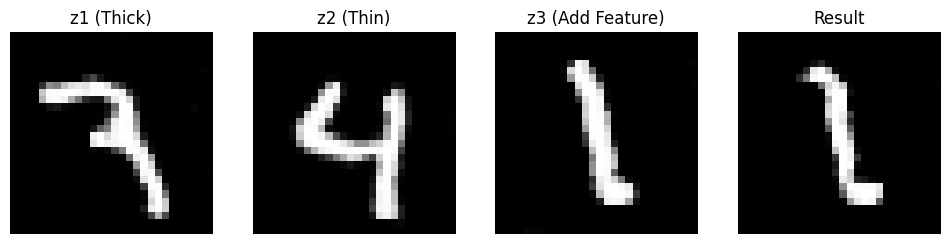

In [19]:
# Part 7: Arithmetic Operation in Latent Space
def arithmetic_latent_space(generator, latent_dim, z1, z2, z3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    generator.eval()

    z1, z2, z3 = z1.to(device), z2.to(device), z3.to(device)

    # arithmetic in latent space:  z1 - z2 + z3
    z_result = z1 - z2 + z3

    # Generate images
    with torch.no_grad():
        img1 = generator(z1).cpu()
        img2 = generator(z2).cpu()
        img3 = generator(z3).cpu()
        img_result = generator(z_result).cpu()

    # Rescale to [0, 1]
    imgs = [(img + 1) / 2 for img in [img1, img2, img3, img_result]]

    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    titles = ["z1 (Thick)", "z2 (Thin)", "z3 (Add Feature)", "Result"]

    for ax, img, title in zip(axs, imgs, titles):
        ax.imshow(img.squeeze(0).squeeze(0).detach().numpy(), cmap="gray")
        ax.set_title(title)
        ax.axis("off")

    plt.show()



# arithmetic operation in latent space
z1 = torch.randn(1, model_params['latent_dim'], 1, 1)
z2 = torch.randn(1, model_params['latent_dim'], 1, 1)
z3 = torch.randn(1, model_params['latent_dim'], 1, 1)
arithmetic_latent_space(generator, model_params['latent_dim'], z1, z2, z3)
